In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
# import torchvision.transforms as transforms
import transforms
import torch.utils.data as data
from PIL import Image
from net import *
import time
import matplotlib.pyplot as plt


def make_datapath_list():
    train_img_list = []
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)

    return train_img_list


class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img)

        return img_transformed


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def train_model(G, D, dataloader, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device is", device)

    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction="mean")

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)

    G.train()
    D.train()

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        print("-----------------------------")
        print("Epoch {}/{}".format(epoch, num_epochs))
        print("-----------------------------")
        print(" (train) ")

        for images in dataloader:
            if images.size()[0] == 1:
                continue

            images = images.to(device)

            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            d_out_real = D(images)

            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # Genaratorの学習
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print("-----------------------------")
        print("epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}".format(
            epoch, epoch_d_loss / batch_size, epoch_g_loss / batch_size
        ))
        print("timer: {:.4f}, sec.".format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


if __name__ == "__main__":

    train_img_list = make_datapath_list()
    mean = (0.5,)
    std = (0.5,)
    train_dataset = GAN_Img_Dataset(
        file_list=train_img_list, transform=ImageTransform(mean, std))

    batch_size = 64

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    # batch_iterator = iter(train_dataloader)
    # images = next(batch_iterator)
    # print(images.size())

    G = Generator(z_dim=20, image_size=64)
    D = Discriminator(z_dim=20, image_size=64)

    G.apply(weights_init)
    D.apply(weights_init)

    print("ネットワークの初期化完了")

    num_epochs = 200
    G_update, D_update = train_model(
        G, D, dataloader=train_dataloader, num_epochs=num_epochs)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




ch_D_Loss:4.8628 ||Epoch_G_Loss:12.9796
timer: 0.5329, sec.
-----------------------------
Epoch 95/200
-----------------------------
 (train) 
-----------------------------
epoch 95 || Epoch_D_Loss:3.8305 ||Epoch_G_Loss:12.7916
timer: 0.5951, sec.
-----------------------------
Epoch 96/200
-----------------------------
 (train) 
-----------------------------
epoch 96 || Epoch_D_Loss:5.6812 ||Epoch_G_Loss:12.4594
timer: 0.5678, sec.
-----------------------------
Epoch 97/200
-----------------------------
 (train) 
-----------------------------
epoch 97 || Epoch_D_Loss:4.4083 ||Epoch_G_Loss:12.3270
timer: 0.5232, sec.
-----------------------------
Epoch 98/200
-----------------------------
 (train) 
-----------------------------
epoch 98 || Epoch_D_Loss:3.3311 ||Epoch_G_Loss:13.6776
timer: 0.6579, sec.
-----------------------------
Epoch 99/200
-----------------------------
 (train) 
-----------------------------
epoch 99 || Epoch_D_Loss:6.0799 ||Epoch_G_Loss:12.8719
timer: 0.5204, sec.


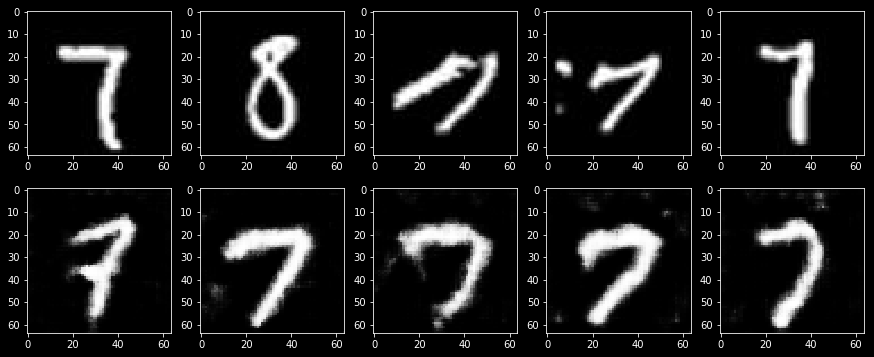

In [5]:
# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), "gray")

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), "gray")